# Building a Handwritten Digits Classifier

Our **goal in this project** is to explore and understand the challenging task of image classification. We want to observe the limitations of traditional Machine Learning (ML) models, then train, test, and improve some **Deep Neural Networks (DNN)** for **image classification.**

[This is a link to the brief history of DNNs.]('https://arxiv.org/pdf/1803.01164.pdf')

## Why is Image Classification a hard task?

Within the field of machine learning and pattern recognition, image classification (especially for handwritten text) is towards the difficult end of the spectrum. There are a few reasons for this.

First, each image in a training set is high dimensional. Each pixel in an image is a feature and a separate column. This means that a 128 x 128 image has 16384 features.

Second, images are often downsampled to lower resolutions and transformed to grayscale (no color). This is a limitation of compute power unfortunately. The resolution of a 8 megapixel photo has 3264 by 2448 pixels, for a total of 7,990,272 features (or about 8 million). Images of this resolution are usually scaled down to between 128 and 512 pixels in either direction for significantly faster processing. This often results in a loss of detail that's available for training and pattern matching.

Third, the features in an image don't have an obvious linear or nonlinear relationship that can be learned with a model like linear or logistic regression. In grayscale, each pixel is just represented as a brightness value ranging from 0 to 256. 

**In this Project, we'll explore the effectiveness of deep, feedforward neural networks at classifying images.**

## Working with image data

In the **Scikit-Learn** library there are a number of pre-loaded datasets. The *load_digits()* function returns a copy of the [Hand-written Digits dataset]('http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits') from University of California, Irvine.

Because dataframes are a tabular representation of data, each image is represented as a row of pixel values. To visualize an image from the dataframe, we need to reshape the image back to its original dimensions (28 x 28 pixels). To visualize the image, we need to reshape these pixel values back into the 28 by 28 and plot them on a coordinate grid.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import accuracy_score

data = load_digits(as_frame=True)
imgs = data.data
target = data.target

In [2]:
print(imgs.shape, '\n')
imgs.head()

(1797, 64) 



,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


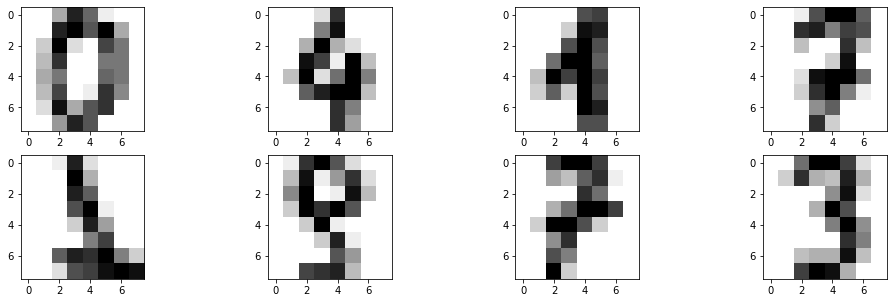

In [3]:
# select 8 images from the data and plot them
sample = imgs.iloc[[0,100,200,300,1000,1100,1200,1300],:]
sample.reset_index(inplace=True, drop=True)

fig, axs = plt.subplots(2, 4, figsize=(17,5))
for i, ax in enumerate(axs.flat):
    img = sample.iloc[i,:].values.reshape(8,8)
    ax.imshow(img, cmap='gray_r')

## Logistic Regression

Let us first instantiate a Logistic Regression model to creat a baseline. We are expecting to improve our model's accuracy with the K-Nearest Neighbors algorithm and Neural Networks in the following sections.

In [4]:
# split the data into train and test sets
imgs_target = pd.concat([imgs, target], axis=1)
imgs_target = imgs_target.sample(frac=1, random_state=1)
train_data = imgs_target.groupby('target').apply(lambda x: x.sample(frac=0.85, random_state=1))
train_data = train_data.droplevel('target').sample(frac=1, random_state=1)
test_data = imgs_target.loc[~imgs_target.index.isin(train_data.index)]
train_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)

X_train, y_train = train_data.iloc[:, :-1], train_data.target
X_test, y_test = test_data.iloc[:, :-1], test_data.target

# perform Logistic Regression to find a baseline
lr = LogisticRegression(solver='newton-cg')
lr.fit(X_train, y_train)
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)
train_acc_score = accuracy_score(y_train, train_preds)
test_acc_score = accuracy_score(y_test, test_preds)
print('Logistic Regression Results:')
print('Training Accuracy Score: ', round(train_acc_score, 3))
print('Test Accuracy Score: ', round(test_acc_score, 3))

Logistic Regression Results:
Training Accuracy Score:  1.0
Test Accuracy Score:  0.948


## K-Nearest Neighbors algorithm

While linear and logistic regression models make assumptions about the linearity between the features and the output labels, the k-nearest neighbors **(KNN)** algorithm make no such assumption. This allows them to capture nonlinearity in the data. If you recall, k-nearest neighbors don't have a specific model representation (hence why it's referred to as an algorithm and not a model).

We need to split our data into train and test sets. Then we can instantiate a KNN model and, of course, validate it. It is also very important that we thoroughly shuffle the data to get rid of any patterns that will distract our Neural Network.

In [5]:
# setup a pipeline of functions for KNN models
def train_knn(k, train_features, train_target):
    model = KNeighborsClassifier(k)
    model.fit(train_features, train_target)
    return model
def test(model, test_features, test_target):
    preds = model.predict(test_features)
    return accuracy_score(test_target, preds)
def knn_cross_validate(df, target, k, n_splits=10):
    train_acc = []
    test_acc = []
    kf = KFold(n_splits, shuffle=True, random_state=1)
    for train_index, test_index in kf.split(df):
        train_f, test_f = df.loc[train_index], df.loc[test_index]
        train_l, test_l = target.loc[train_index], target.loc[test_index]
        model = train_knn(k, train_f, train_l)
        train_accuracy = test(model, train_f, train_l)
        test_accuracy = test(model, test_f, test_l)
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)
    return round(np.mean(train_acc), 3), round(np.mean(test_acc), 3)

In [6]:
# test function pipeline
print('K-Nearest Neighbors algorithm:')
print('Train accuracy:', knn_cross_validate(imgs, target, 5)[0])
print('Test accuracy:', knn_cross_validate(imgs, target, 5)[1])

K-Nearest Neighbors algorithm:
Train accuracy: 0.99
Test accuracy: 0.988


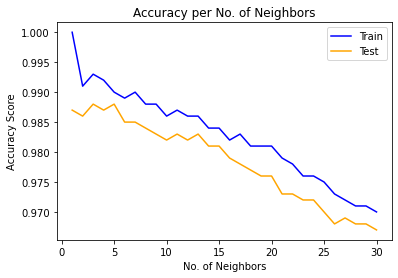

In [7]:
# plot different instances of K neighbors
K_neighbors = list(range(1,31))
train_accuracy_scores = []
test_accuracy_scores = []
for i in K_neighbors:
    train_accuracy_scores.append(knn_cross_validate(imgs, target, i)[0])
    test_accuracy_scores.append(knn_cross_validate(imgs, target, i)[1])
plt.plot(K_neighbors, train_accuracy_scores, c='blue', label='Train')
plt.plot(K_neighbors, test_accuracy_scores, c='orange', label='Test')
plt.title('Accuracy per No. of Neighbors')
plt.legend()
plt.xlabel('No. of Neighbors')
plt.ylabel('Accuracy Score')
plt.show()

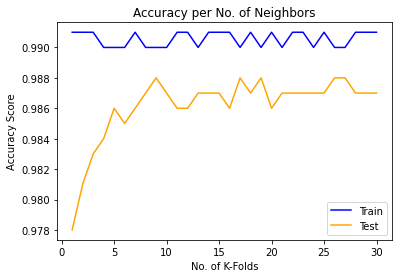

In [8]:
# plot different instances of K-Folds
K_folds = list(range(2,32))
train_accuracy_scores = []
test_accuracy_scores = []
for i in K_folds:
    train_accuracy_scores.append(knn_cross_validate(imgs, target, 5, n_splits=i)[0])
    test_accuracy_scores.append(knn_cross_validate(imgs, target, 5, n_splits=i)[1])
plt.plot(K_neighbors, train_accuracy_scores, c='blue', label='Train')
plt.plot(K_neighbors, test_accuracy_scores, c='orange', label='Test')
plt.title('Accuracy per No. of Neighbors')
plt.legend()
plt.xlabel('No. of K-Folds')
plt.ylabel('Accuracy Score')
plt.show()

The last two graphs tell us that we need **5 neighbor groups** and **10-fold cross validation** to obtain the most optimized algorithm.

## Limitations of the K-NN algorithm:

There are a few downsides to the k-nn algo:

 - high memory usage
    - for each new unseen observation, many comparisons need to be made to seen observations
 - there isn't a model representation to debug and explore


# Neural Networks

First, we are going to try a neural network (NN) with a single hidden layer. We'll use the `MLPClassifier` package from sci-kit learn, and we'll start by using 4-fold cross validation. We will train and test a NN with 8, 16, 32, 64, 128, and 256 neurons in that single layer.

Next, we'll rank the performance of the models by the overall accuracies. We want to see if these models are overfitting to the train data (perform well on the train set but poorly on the test set).

In [9]:
# set up a pipeline of functions
def perceptron_cross_validate(X, y, 
          hidden_layer_sizes, activation='relu', 
          max_iter=1500, n_folds=5, random_state=1):
    mlp = MLPClassifier(hidden_layer_sizes,
                       activation=activation,
                       random_state=random_state,
                       max_iter=max_iter)
    cross_val_results = cross_validate(mlp, X, y, scoring='accuracy',
                                      cv=n_folds, return_train_score=True)
    train_acc = np.average(cross_val_results['train_score'])
    test_acc = np.average(cross_val_results['test_score'])
    
    return round(train_acc, 3), round(test_acc, 3)

# wrapper
def cross_validate_all(X, y, hidden_layers, activation='relu',
                      max_iter=1500, n_folds=5, print_progress=True):
    train_accuracies = []
    test_accuracies = []
    
    for architecture in hidden_layers:
        train_acc, test_acc = perceptron_cross_validate(
        X, y, architecture, activation, max_iter, n_folds)
        if print_progress:
            print(f'{architecture} neurons network: done.')
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        
    results = pd.DataFrame(zip(train_accuracies, test_accuracies),
                              index=hidden_layers, columns=['train','test'])
    return results

def plot_results(results, x_label, y_label, title,
                y_lims=(0.87, 1.0), figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)
    results.plot(kind='bar', ax=ax)
    ax.set_ylim(y_lims[0], y_lims[1])
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=0, fontsize=13)
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_title(title, fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
    return None    

In [10]:
architectures = [(2 ** n, ) for n in range(1, 10)]

results_df = cross_validate_all(imgs, target, architectures)
results_df

(2,) neurons network: done.
(4,) neurons network: done.
(8,) neurons network: done.
(16,) neurons network: done.
(32,) neurons network: done.
(64,) neurons network: done.
(128,) neurons network: done.
(256,) neurons network: done.
(512,) neurons network: done.


,train,test
"(2,)",0.332,0.289
"(4,)",0.887,0.785
"(8,)",0.998,0.886
"(16,)",1.000,0.917
"(32,)",1.000,0.924
"(64,)",1.000,0.926
"(128,)",1.000,0.942
"(256,)",1.000,0.940
"(512,)",1.000,0.945


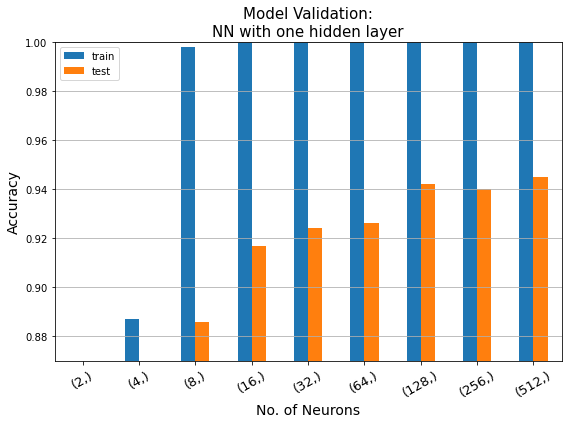

In [11]:
plot_results(results_df, 'No. of Neurons','Accuracy','Model Validation:\nNN with one hidden layer')

Based on the graph above, we need a minimum of 16 neurons to get good accuracy on our test data. Additionally, our best performers were the NN with 128, 256, and 512 neurons, which is not surprising.

The fewer the neurons, the more it appears the model is overfitting. However, from 16 neurons and up the Neural Network is performing very well.

## Neural Network with 2 hidden layers

So, adding more neurons to a single hidden layer vastly improved the classification accuracy. Let's try using two hidden layers and continue to increase the number of neurons in each layer.

In [12]:
arch_2 = [(2 ** n, 2 ** n) for n in range(1, 9)]

results_df2 = cross_validate_all(imgs, target, arch_2)
results_df2

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  warnings.warn(


(2, 2) neurons network: done.
(4, 4) neurons network: done.
(8, 8) neurons network: done.
(16, 16) neurons network: done.
(32, 32) neurons network: done.
(64, 64) neurons network: done.
(128, 128) neurons network: done.
(256, 256) neurons network: done.


,train,test
"(2, 2)",0.590,0.525
"(4, 4)",0.814,0.707
"(8, 8)",1.000,0.892
"(16, 16)",1.000,0.912
"(32, 32)",1.000,0.922
"(64, 64)",1.000,0.934
"(128, 128)",1.000,0.951
"(256, 256)",1.000,0.952


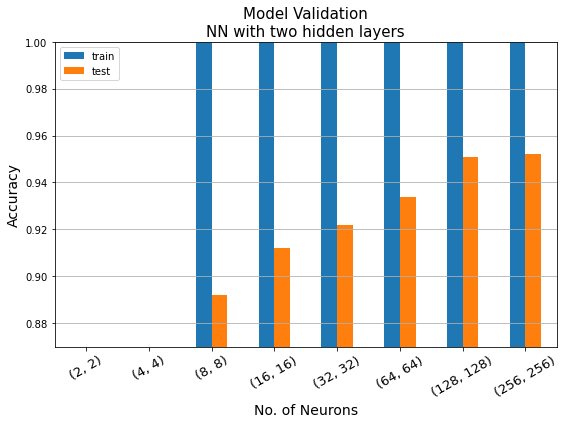

In [13]:
plot_results(results_df2, 'No. of Neurons','Accuracy','Model Validation\nNN with two hidden layers')

My hypothesis was that adding a second layer to the NN would improve it's accuracy, however it is objectively less accurate. 

We received an error during while creating `results_df2`:

`Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.`

This tells us that optimization did not converge, which means that with more iterations we could potentially get higher accuracy. It already took a while for this NN to run, so for efficiency reasons we will move on for now.

## Adding more layers

Using more hidden layers is known to increase the amount of overfitting that happens. To help us prevent overfitting, let's increase the number of folds we use for k-fold cross validation to 6 while testing networks with 3 hidden layers of 10 neurons each. Then we will do the same with 64 neurons each, then 128 each.

In [14]:
arch_3 = [(10,10,10),
         (64,64,64),
         (128,128,128)]

results_df3 = cross_validate_all(imgs, target, arch_3, n_folds=6)
results_df3

(10, 10, 10) neurons network: done.
(64, 64, 64) neurons network: done.
(128, 128, 128) neurons network: done.


,train,test
"(10, 10, 10)",1.0,0.917
"(64, 64, 64)",1.0,0.954
"(128, 128, 128)",1.0,0.955


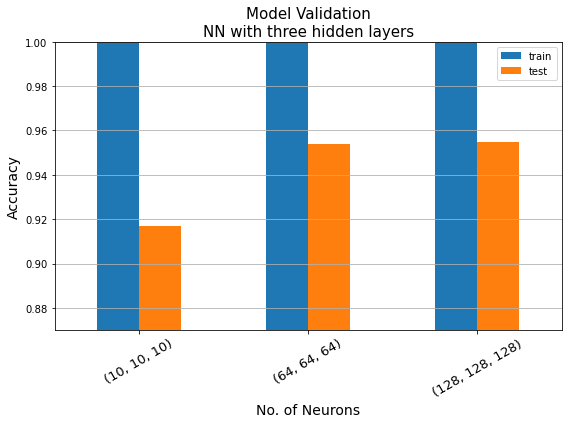

In [16]:
plot_results(results_df3, 'No. of Neurons','Accuracy','Model Validation\nNN with three hidden layers')

Having three hidden layers slightly improved our model's performance over two hidden layers, but the single-layer high-neuron-count NN still performed better. 

# Conclusion

None of the Neural Networks performed as accurately as the k-Nearest Neighbors algorithm, which was a big surprise to me. Therefore, we can say that the use of a multi-layer perceptron is not justified with this dataset. Neural Networks work better with larger datasets because they have more information to go off of. Our dataset is most likely too small to see a drastic increase in accuracy from simpler models up to NNs.

## Potential next steps

We could also test different types of models such as Decision Trees and Random Forest Models.

We could also experiment with different activation functions to see if the accuracies improve.

Furthermore, we could research some techniques for visualizing weights in neural network models and add a visualization step to our pipeline.